# Course project on topic "Python libraries for Data Science: Numpy, Matplotlib, Scikit-learn continuation"

* [Data loading](#loads)
* [1. EDA](#edas)
* [2. Handling outliers](#outliers)
* [3. Handling missing values](#nans)
* [4. Constructing new features](#features)
* [5. Splitting on train and test](#splits)
* [6. Building a model](#models)
* [7. Predicting on the test dataset](#prediction)

### Importing libraries and functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score as f1, precision_score, recall_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

%matplotlib inline
%config InlineBackend.figure_format='svg'
pd.options.display.max_columns = 100

import warnings
warnings.filterwarnings('ignore')

In [2]:
def analyze(df , column):
    df = df.copy()
    df = df.loc[~df[column].isna()]
    # global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q75 + cut_off
    print('The IQR is',iqr)
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    print('Total number of outliers are', df1.shape[0]+ df2.shape[0])
    
    plt.figure(figsize=(6, 3))

    sns.boxplot(df[column], whis=1.5)

    plt.xlabel(column)
    plt.show()

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train F1:\t" + str(round(f1(train_true_values, train_pred_values), 4)))
    print("Test F1:\t" + str(round(f1(test_true_values, test_pred_values), 4)))

In [4]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 17):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (12, 4))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.3, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

### Paths to directories and files

In [5]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

## Data loading <a class='anchor' id='loads'>

#### Dataset description

#### Data fields  
**Home Ownership** - what it says  
**Annual Income** - what it says  
**Years in current job** - what it says  
**Tax Liens** - what it says  
**Number of Open Accounts** - what it says  
**Years of Credit History** - what it says  
**Maximum Open Credit** - maximum amount ever available to a client  
**Number of Credit Problems** - what it says  
**Months since last delinquent** - what it says  
**Bankruptcies** - number of bankruptcies  
**Purpose** - purpose of the credit  
**Term** - term of the credit  
**Current Loan Amount** - amount, still needed to be paid  
**Current Credit Balance** - amount, available to a client for spending  
**Monthly Debt** - what it says  
**Credit Score** - what it says  
**Credit Default** - fact of non-fulfillment of credit obligations (0 - repaid in time, 1 - delinquency)

In [6]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [7]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

## EDA <a class='anchor' id='edas'>

#### Target variable

In [8]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

#### Continuous variables

In [9]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


#### Categorical variables

In [10]:
df.select_dtypes(include='object').columns.tolist()

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [11]:
df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [12]:
df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [13]:
df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [14]:
df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

## Handling outliers <a class='anchor' id='outliers'>

#### Annual Income

In [15]:
df['Annual Income'].value_counts()

1338113.0    4
969475.0     4
1161660.0    4
1043651.0    4
1058376.0    4
            ..
1272316.0    1
712082.0     1
695476.0     1
678889.0     1
402192.0     1
Name: Annual Income, Length: 5478, dtype: int64

The IQR is 795796.0
The lower bound value is -349353.0
The upper bound value is 2833831.0
Total number of outliers are 287


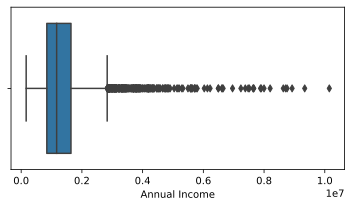

In [16]:
analyze(df, 'Annual Income')

We'll consider there are no outliers.

#### Tax Liens

In [17]:
df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

The attribute will be deleted due to an overwhelming number of one value.

#### Number of Open Accounts

In [18]:
df['Number of Open Accounts'].value_counts()

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      2
43.0      1
41.0      1
38.0      1
35.0      1
42.0      1
Name: Number of Open Accounts, dtype: int64

The IQR is 6.0
The lower bound value is -1.0
The upper bound value is 23.0
Total number of outliers are 170


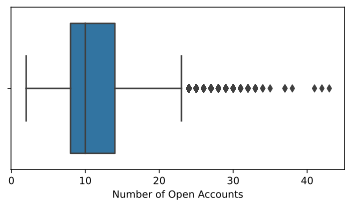

In [19]:
analyze(df, 'Number of Open Accounts')

We'll consider there are no outliers.

#### Years of Credit History

In [20]:
df['Years of Credit History'].value_counts()

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
44.0      1
39.8      1
40.0      1
39.9      1
48.3      1
Name: Years of Credit History, Length: 408, dtype: int64

The IQR is 8.3
The lower bound value is 1.049999999999999
The upper bound value is 34.25
Total number of outliers are 228


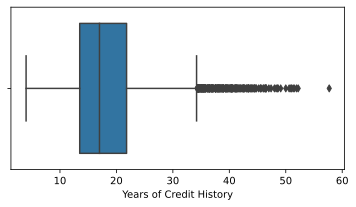

In [21]:
analyze(df, 'Years of Credit History')

We'll consider there are no outliers.

#### Maximum Open Credit

In [22]:
df['Maximum Open Credit'].value_counts()

0.0         65
319110.0     5
246224.0     3
344058.0     3
513524.0     3
            ..
668360.0     1
642224.0     1
779372.0     1
372812.0     1
480832.0     1
Name: Maximum Open Credit, Length: 6963, dtype: int64

The IQR is 514272.0
The lower bound value is -492178.5
The upper bound value is 1564909.5
Total number of outliers are 466


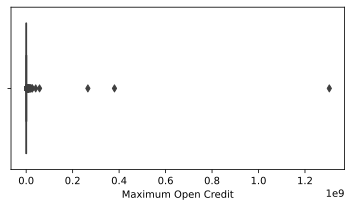

In [23]:
analyze(df, 'Maximum Open Credit')

In [24]:
df.loc[df['Maximum Open Credit'] > 0.2 * 10 ** 9, 'Maximum Open Credit'] = df['Maximum Open Credit'].median()

The IQR is 513936.5
The lower bound value is -491675.25
The upper bound value is 1564070.75
Total number of outliers are 463


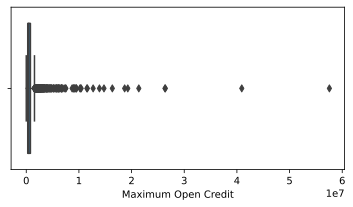

In [25]:
analyze(df, 'Maximum Open Credit')

We replaced values which were beyond reason.

#### Number of Credit Problems

In [26]:
df['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

The feature will be converted to binary.

#### Months since last delinquent

In [27]:
df['Months since last delinquent'].value_counts()

14.0     76
29.0     71
33.0     68
8.0      68
12.0     65
         ..
86.0      1
118.0     1
84.0      1
91.0      1
92.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

The IQR is 34.0
The lower bound value is -35.0
The upper bound value is 101.0
Total number of outliers are 1


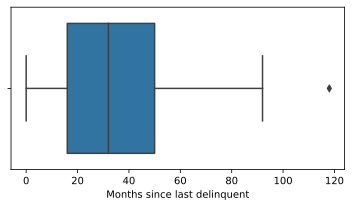

In [28]:
analyze(df, 'Months since last delinquent')

We'll consider there are no outliers.

#### Bankruptcies

In [29]:
df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

The feature will be converted to binary.

#### Current Loan Amount

In [30]:
df['Current Loan Amount'].value_counts()

99999999.0    870
218064.0        6
89298.0         6
222926.0        5
265826.0        5
             ... 
351626.0        1
212498.0        1
187682.0        1
108922.0        1
26928.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

The IQR is 339713.0
The lower bound value is -329400.5
The upper bound value is 1029451.5
Total number of outliers are 870


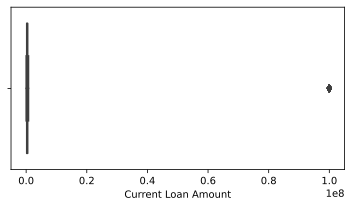

In [31]:
analyze(df, 'Current Loan Amount')

In [32]:
df.loc[df['Current Loan Amount'] == 99999999, 'Credit Default'].unique()

array([0], dtype=int64)

The analysis shows that the dataset has 870 values of Current Loan Amount, which are equal to 99999999.  
For each of these values the target label is 0. Thus, we may conclude that these are people who already  
repaid the credit. Despite the high probability of model overfitting this feature, it was decided to leave  
it because it gives correct predictions when we see these same values in the test dataset. The experiments  
showed decreasing of F1 metric when removing rows with values 99999999 from the train dataset.

In [33]:
df.loc[df['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = 0

The IQR is 267267.0
The lower bound value is -271238.0
The upper bound value is 797830.0
Total number of outliers are 0


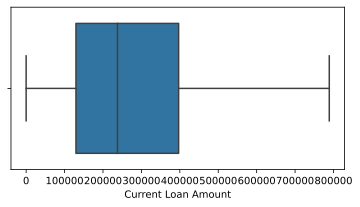

In [34]:
analyze(df, 'Current Loan Amount')

We replaced these values with 0, because these people owe the bank nothing, and a small value  
of this feature, theoretically, decreasing the probability of default.

#### Current Credit Balance

In [35]:
df['Current Credit Balance'].value_counts()

0.0         53
191710.0     5
106818.0     4
83638.0      4
136401.0     4
            ..
445360.0     1
243371.0     1
25688.0      1
62054.0      1
288192.0     1
Name: Current Credit Balance, Length: 6592, dtype: int64

The IQR is 246149.75
The lower bound value is -254968.125
The upper bound value is 729630.875
Total number of outliers are 440


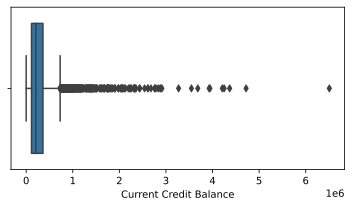

In [36]:
analyze(df, 'Current Credit Balance')

We'll consider there are no outliers.

#### Monthly Debt

In [37]:
df['Monthly Debt'].value_counts()

0.0        6
19222.0    4
19667.0    4
12986.0    3
13356.0    3
          ..
33217.0    1
8203.0     1
15150.0    1
1992.0     1
9061.0     1
Name: Monthly Debt, Length: 6716, dtype: int64

The IQR is 13750.5
The lower bound value is -10558.25
The upper bound value is 44443.75
Total number of outliers are 255


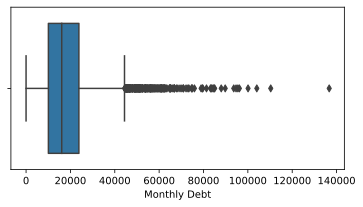

In [38]:
analyze(df, 'Monthly Debt')

In [39]:
df.loc[df['Monthly Debt'] == 0].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
780,Home Mortgage,867749.0,10+ years,0.0,2.0,16.5,0.0,0.0,66.0,0.0,home improvements,Short Term,75350.0,0.0,0.0,704.0,0
1643,Rent,NaN,9 years,0.0,3.0,10.0,0.0,0.0,NaN,0.0,other,Short Term,332156.0,0.0,0.0,NaN,1
3219,Home Mortgage,NaN,10+ years,0.0,3.0,18.5,0.0,0.0,NaN,0.0,debt consolidation,Short Term,79200.0,0.0,0.0,NaN,0
3496,Rent,233567.0,1 year,0.0,7.0,11.7,0.0,0.0,0.0,NaN,educational expenses,Short Term,210166.0,0.0,0.0,746.0,0
4165,Rent,1254513.0,10+ years,0.0,6.0,23.4,0.0,0.0,60.0,0.0,take a trip,Short Term,0.0,0.0,0.0,748.0,0


We'll consider values 0 as outliers, because otherwise it looks like there are people  
who owe to the bank and have zero monthly debt.

In [40]:
df.loc[df['Monthly Debt'] == 0, 'Monthly Debt'] = df.median()['Monthly Debt']

#### Credit Score

In [41]:
df['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
742.0     151
         ... 
616.0       1
6600.0      1
629.0       1
6820.0      1
6060.0      1
Name: Credit Score, Length: 268, dtype: int64

The IQR is 32.0
The lower bound value is 663.0
The upper bound value is 791.0
Total number of outliers are 662


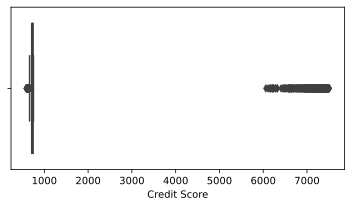

In [42]:
analyze(df, 'Credit Score')

There are values which are ~10 times greater than the majority of values, and there is  
a significant gap in these values' distributions. We'll consider standing out values as  
outliers and divide them by 10.

In [43]:
df.loc[df['Credit Score'] > 5000, 'Credit Score'] = df['Credit Score'] / 10

The IQR is 32.0
The lower bound value is 660.0
The upper bound value is 788.0
Total number of outliers are 271


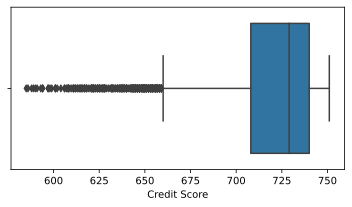

In [44]:
analyze(df, 'Credit Score')

## Handling missing values <a class='anchor' id='nans'>

In [45]:
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [46]:
df.loc[df['Annual Income'].isna(), 'Credit Score'].isna().sum()

1557

Missing values of Annual Income and Credit Score match each other. Experiments were conducted  
involving training a regression model to predict values of these features by other features.  
However, the quality of these predictions left much to be desired. Ultimately, it was decided  
to replace the missing values with medians along with creating a feature which points at the fact  
of initial absence of Annual Income and Credit Score values in these rows.

#### Annual Income

In [47]:
df['Annual Income'].fillna(df['Annual Income'].median(), inplace=True)

#### Credit Score

In [48]:
df['income_cred_score_nan'] = 0

In [49]:
df.loc[df['Credit Score'].isna(), 'income_cred_score_nan'] = 1

In [50]:
df['Credit Score'].fillna(df['Credit Score'].median(), inplace=True)

#### Years in current job

It was decided to think of missing values in this feature as of jobless people and replace  
them with 0. Later this feature will be converted to binary.

In [51]:
df['Years in current job'].fillna(0, inplace=True)

#### Months since last delinquent

It was decided to think of missing values in this feature as of those people, who have never  
allowed delinquency, and replace them with an obviously big value, which will be processed later.

In [52]:
df['Months since last delinquent'].fillna(999, inplace=True)

#### Bankruptcies

Considering missing values in this feature as missing data, so, by default, we'll  
count them as no bankruptcies.

In [53]:
df['Bankruptcies'].fillna(0, inplace=True)

In [54]:
class DataPreprocessing:
    
    def __init__(self):
        
        self.medians = None
        
    def fit(self, X):
        
        self.medians = X.median()
    
    def transform(self, X):
        
        # Annual Income
        X['Annual Income'].fillna(self.medians['Annual Income'], inplace=True)
        
        # Maximum Open Credit
        X.loc[X['Maximum Open Credit'] > 0.2 * 10 ** 9, 'Maximum Open Credit'] = self.medians['Maximum Open Credit']
        
        # Current Loan Amount
        X.loc[X['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = 0
        
        # Credit Score
        X.loc[X['Credit Score'] > 5000, 'Credit Score'] = X['Credit Score'] / 10
        X['income_cred_score_nan'] = 0
        X.loc[X['Credit Score'].isna(), 'income_cred_score_nan'] = 1
        X['Credit Score'].fillna(self.medians['Credit Score'], inplace=True)
        
        # Years in current job
        X['Years in current job'].fillna(0, inplace=True)
        
        # Months since last delinquent
        X['Months since last delinquent'].fillna(999, inplace=True)
        
        # Bankruptcies
        X['Bankruptcies'].fillna(0, inplace=True)
        
        # Monthly Debt
        X.loc[X['Monthly Debt'] == 0, 'Monthly Debt'] = self.medians['Monthly Debt']
        
        X.fillna(self.medians, inplace=True)
        
        return X

## Constructuing new features <a class='anchor' id='features'>

#### Home Ownership

We'll count values Have Mortgage and Home Mortgage equal. Then we'll do one-hot-encoding.

In [55]:
df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

In [56]:
df = pd.get_dummies(df, columns=['Home Ownership'])

#### Years in current job

In [57]:
df.loc[~df['Years in current job'].isin([0]), 'Years in current job'] = 1

In [58]:
df['Years in current job'] = df['Years in current job'].astype(int)

Making the feature binary:
 
0 - jobless,  
1 - have a job.

#### Purpose

Making the feature binary, replacing all values, other than *debt consolidation*, with *other*.

In [59]:
df.loc[~df['Purpose'].isin(['debt consolidation', 'other']), 'Purpose'] = 'other'
df['Purpose'].replace({'debt consolidation': 0, 'other': 1}, inplace=True)

In [60]:
df['Purpose'].value_counts()

0    5944
1    1556
Name: Purpose, dtype: int64

#### Term

In [61]:
df['Term'].replace({'Short Term': 0, 'Long Term': 1}, inplace=True)

#### Tax Liens

In [62]:
df.drop('Tax Liens', axis=1, inplace=True)

#### Number of Open Accounts

Splitting values into bins:

In [63]:
bins = [-1, 7, 13, 18, df['Number of Open Accounts'].max()]
df['Number of Open Accounts'] = pd.cut(df['Number of Open Accounts'], bins=bins, labels=False)

#### Years of Credit History

In [64]:
bins = [-1, 9, 14, df['Years of Credit History'].max()]
df['Years of Credit History'] = pd.cut(df['Years of Credit History'], bins=bins, labels=False)

#### Number of Credit Problems

Making the feature binary:

In [65]:
df.loc[df['Number of Credit Problems'] > 1, 'Number of Credit Problems'] = 1

In [66]:
df['Number of Credit Problems'].value_counts()

0.0    6469
1.0    1031
Name: Number of Credit Problems, dtype: int64

#### Months since last delinquent

Splitting values into bins. People, who haven't ever allowed delinquency and have their  
feature value equal 999, will go to the maximum bin.

In [67]:
bins = [-1, 6, 12, 200, df['Months since last delinquent'].max()]
df['Months since last delinquent'] = pd.cut(df['Months since last delinquent'], bins=bins, labels=False)

#### Bankruptcies

Making the feature binary:

In [68]:
df.loc[df['Bankruptcies'] > 1, 'Bankruptcies'] = 1

In [69]:
df['Bankruptcies'].value_counts()

0.0    6674
1.0     826
Name: Bankruptcies, dtype: int64

In [70]:
class FeatureGenerator():
    
    def __init__(self):
        
        self.accounts_max = None
        self.history_years = None
        self.delinquent_months_max = None

    def fit(self, X):
        
        self.accounts_max = X['Number of Open Accounts'].max()
        self.history_years_max = X['Years of Credit History'].max()
        self.delinquent_months_max = X['Months since last delinquent'].max()
        
    def transform(self, X):
        
        # Home Ownership
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
        X = pd.get_dummies(X, columns=['Home Ownership'])

        # Years in current job

        X.loc[~X['Years in current job'].isin([0]), 'Years in current job'] = 1
        X['Years in current job'] = X['Years in current job'].astype(int)
        
        # Purpose
        X.loc[~X['Purpose'].isin(['debt consolidation', 'other']), 'Purpose'] = 'other'
        X['Purpose'].replace({'debt consolidation': 0, 'other': 1}, inplace=True)
        
        # Term
        X['Term'].replace({'Short Term': 0, 'Long Term': 1}, inplace=True)
        
        # Tax Liens
        X.drop('Tax Liens', axis=1, inplace=True)
        
        # Number of Open Accounts
        bins = [-1, 7, 13, 18, self.accounts_max]
        X['Number of Open Accounts'] = pd.cut(X['Number of Open Accounts'], bins=bins, labels=False)
        X['Number of Open Accounts'].fillna(3, inplace=True)
        
        # Years of Credit History
        bins = [-1, 9, 14, self.history_years_max]
        X['Years of Credit History'] = pd.cut(X['Years of Credit History'], bins=bins, labels=False)
        X['Years of Credit History'].fillna(2, inplace=True)
        
        # Number of Credit Problems
        X.loc[X['Number of Credit Problems'] > 1, 'Number of Credit Problems'] = 1

        # Months since last delinquent
        bins = [-1, 6, 12, 200, self.delinquent_months_max]
        X['Months since last delinquent'] = pd.cut(X['Months since last delinquent'], bins=bins, labels=False)
        X['Months since last delinquent'].fillna(3, inplace=True)
        
        # Bankruptcies
        X.loc[X['Bankruptcies'] > 1, 'Bankruptcies'] = 1
        
        return X

## Splitting on train and test <a class='anchor' id='splits'>

In [71]:
target_name = 'Credit Default'

In [72]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(target_name, axis=1)
y = train_df[target_name]

In [73]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=29, stratify=y)

In [74]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((5625, 17), (1875, 17), (2500, 17))

In [75]:
feature_gen = FeatureGenerator()
feature_gen.fit(X_train)

X_train = feature_gen.transform(X_train)
X_valid = feature_gen.transform(X_valid)
test_df = feature_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((5625, 18), (1875, 18), (2500, 18))

## Building a model <a class='anchor' id='models'>

#### Training

In [76]:
model = CatBoostClassifier(silent=True,
                           n_estimators=200,
                           auto_class_weights='Balanced',
                           eval_metric='F1',
                           max_depth=6,
                           eta=0.15,
                           reg_lambda=1.530612244897959,
                           early_stopping_rounds=50,
                           use_best_model=True,
                           random_state=29)

In [77]:
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

#### Final model evaluation

In [78]:
y_pred_train = model.predict(X_train)

In [79]:
y_pred_valid = model.predict(X_valid)

In [80]:
evaluate_preds(y_train, y_pred_train, y_valid, y_pred_valid)

Train F1:	0.5589
Test F1:	0.5487


Checking the necessity of changing the classification threshold:

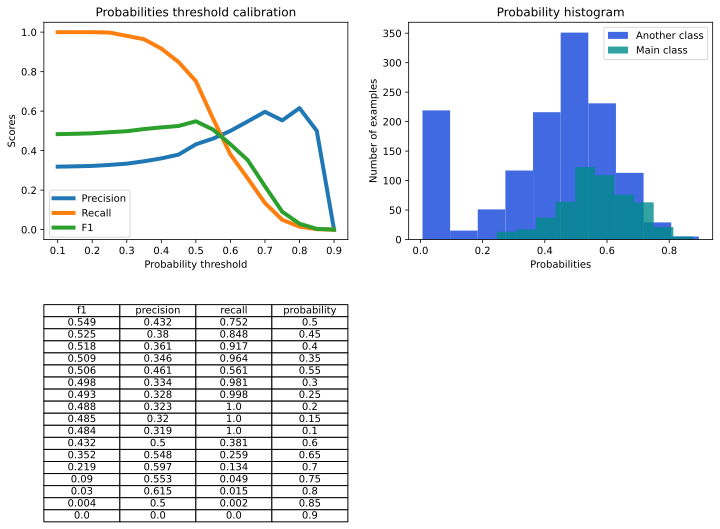

In [81]:
y_valid_pred_probs = model.predict_proba(X_valid)
show_proba_calibration_plots(y_valid_pred_probs[:, 1], y_valid)

We'll leave the threshold at 0.5.

#### Feature importances

In [82]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       model.feature_importances_), 
                                       columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
10,Current Loan Amount,49.414113
0,Annual Income,7.517699
13,Credit Score,7.369077
9,Term,6.774369
4,Maximum Open Credit,4.503666
2,Number of Open Accounts,3.994769
17,Home Ownership_Rent,3.701798
12,Monthly Debt,3.132425
11,Current Credit Balance,2.970064
1,Years in current job,2.743680


## Predicting on the test dataset <a class='anchor' id='prediction'>

In [83]:
sample_pred = pd.read_csv('./sample_submission.csv', index_col='Id')

In [84]:
predictions = model.predict(test_df)

In [85]:
sample_pred[target_name] = predictions

In [86]:
sample_pred.to_csv('./mrozov_prediction.csv')